In [24]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../playwright/results/core-web-vitals/testrun-8/'

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [25]:
df = pd.read_csv(f'{path}2024-12-17T11:09:51.655Z_results-ssrh-sd.csv', sep=',')
df_t = pd.read_csv(f'{path}2024-12-17T12:56:03.620Z_results-ssrh-sd-throttled.csv', sep=',')
df_ht = pd.read_csv(f'{path}2024-12-17T14:52:01.359Z_results-ssrh-sd-throttled-heavy.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config','nf:loaded']

dirty_dfs = {
    'default': df[5:],
    'throttled': df_t[5:],
    'heavy': df_ht[5:],
}

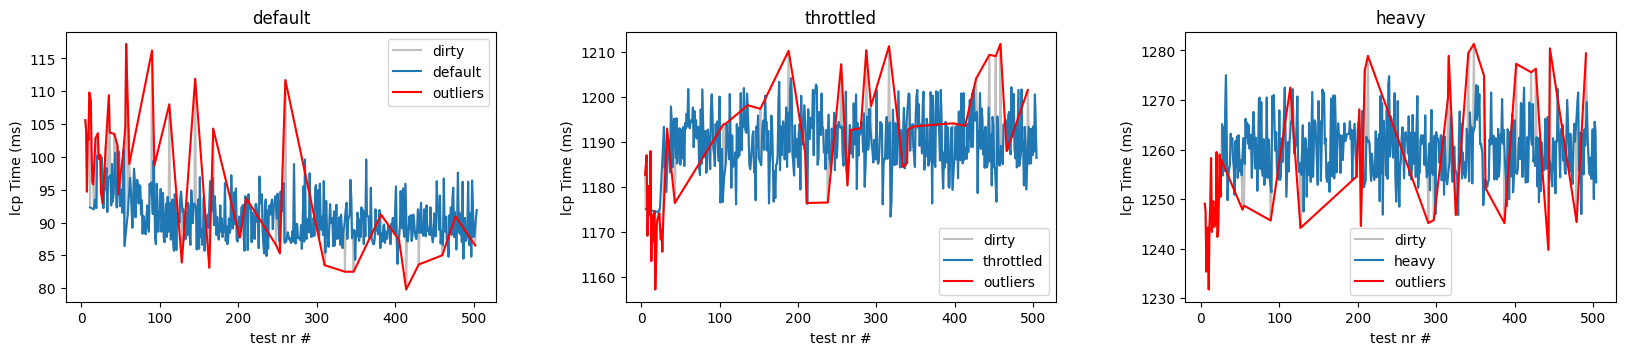

In [26]:
def detect_outliers(_df, _features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(_df[_features])
    return outliers == 1

def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['lcp'], label='dirty', color='gray', alpha=0.5)
    loc.plot(_df['lcp'][mask[d]], label=d)
    loc.plot(_df['lcp'][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'lcp Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.legend()

masks = {}
dfs = {}
target_features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb']

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

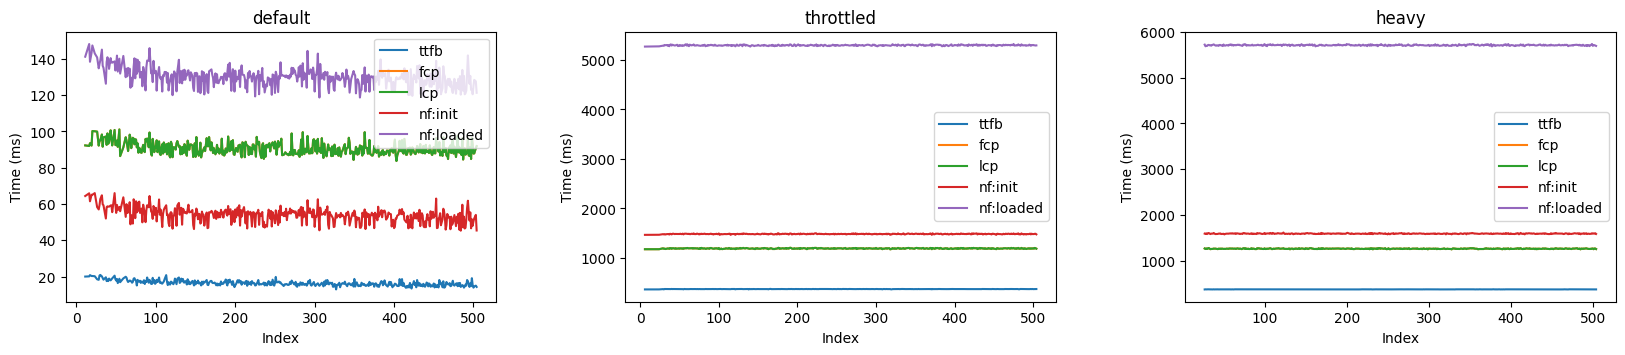

In [27]:
def plot_line(dataset, loc, idx):
    for t in ['ttfb', 'fcp', 'lcp', 'nf:init', 'nf:loaded']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

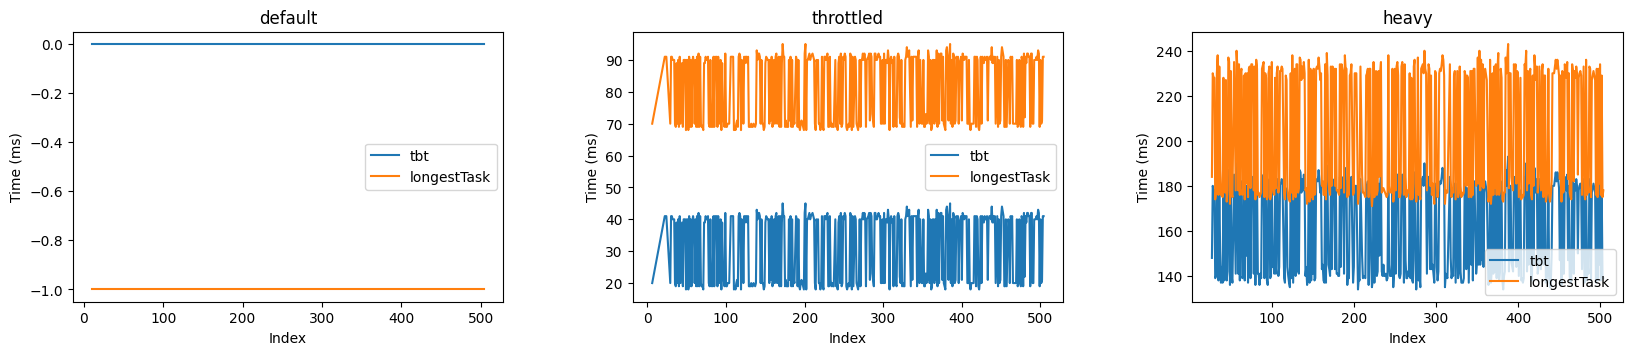

In [28]:
def plot_line(dataset, loc, idx):
    for t in ['tbt', 'longestTask']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

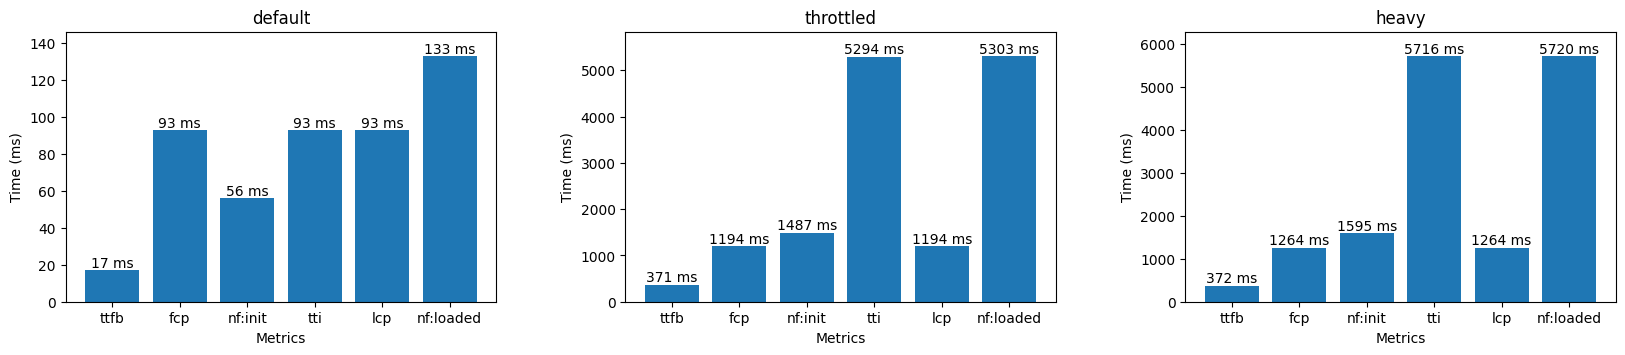

In [29]:
def plot_timeline_bars(dataset, loc, idx):
    metrics = ['ttfb', 'fcp', 'nf:init', 'tti', 'lcp', 'nf:loaded']
    quantiles = [dataset[t].quantile(0.75) for t in metrics]
    bars = loc.bar(metrics, quantiles, label='75th percentile')
    loc.set_xlabel('Metrics')
    loc.set_ylabel('Time (ms)')
    
    for bar in bars:
        height = bar.get_height()
        loc.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f} ms', ha='center', va='bottom')
    
    loc.set_ylim(0, max(quantiles) * 1.1)

graph_row(plot_timeline_bars, dfs)
plt.show()

In [30]:
dfs['default'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,268.33,21.20,87.73,90.62,90.62,16.36,0.00,90.62,0.00,-1.00,53.95,57.55,129.88,NaN
std,137.78,1.52,4.17,3.35,3.35,1.42,0.00,3.35,0.00,0.00,3.99,4.17,5.17,NaN
min,12.00,18.00,78.00,83.70,83.70,12.90,0.00,83.70,0.00,-1.00,45.30,48.40,118.70,NaN
25%,151.25,20.00,85.00,87.90,87.90,15.40,0.00,87.90,0.00,-1.00,52.00,55.40,127.10,NaN
50%,270.50,21.00,87.00,90.00,90.00,16.15,0.00,90.00,0.00,-1.00,54.40,58.00,130.20,NaN
75%,386.75,22.00,90.00,92.70,92.70,17.17,0.00,92.70,0.00,-1.00,56.00,59.80,132.70,NaN
max,505.00,28.00,101.00,101.10,101.10,20.90,0.00,101.10,0.00,-1.00,66.00,70.70,148.20,NaN


In [31]:
dfs['throttled'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,264.58,335.49,5302.60,1190.44,1190.44,369.62,31.26,5283.62,1.00,81.26,1482.99,1694.40,5297.43,NaN
std,139.09,1.72,9.71,6.14,6.14,1.43,10.62,13.51,0.00,10.62,5.80,6.34,9.62,NaN
min,7.00,327.00,5275.00,1173.50,1173.50,362.00,18.00,5246.40,1.00,68.00,1465.50,1673.40,5271.50,NaN
25%,144.25,335.00,5295.00,1185.83,1185.83,369.00,20.00,5274.40,1.00,70.00,1480.20,1689.12,5290.20,NaN
50%,262.50,336.00,5302.50,1190.75,1190.75,369.70,40.00,5283.60,1.00,90.00,1482.20,1695.40,5297.30,NaN
75%,384.75,336.00,5308.00,1194.20,1194.20,370.60,41.00,5293.50,1.00,91.00,1487.48,1696.50,5303.10,NaN
max,505.00,338.00,5330.00,1204.20,1204.20,373.30,45.00,5314.80,1.00,95.00,1497.30,1710.90,5323.90,NaN


In [32]:
dfs['heavy'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,264.46,345.28,5725.59,1260.22,1260.22,370.93,161.15,5707.45,2.50,204.42,1590.14,1813.71,5713.33,NaN
std,138.43,1.18,10.58,5.70,5.70,0.85,21.10,11.48,0.50,27.72,6.47,6.78,10.45,NaN
min,28.00,342.00,5698.00,1246.80,1246.80,369.20,134.00,5676.40,2.00,171.00,1573.60,1797.90,5685.90,NaN
25%,145.25,344.00,5718.00,1255.22,1255.22,370.20,140.00,5699.60,2.00,177.00,1584.72,1807.93,5706.23,NaN
50%,262.50,345.00,5725.00,1261.20,1261.20,371.00,150.50,5707.10,3.00,186.00,1590.25,1814.00,5712.60,NaN
75%,383.75,346.00,5733.00,1263.50,1263.50,371.60,182.00,5715.58,3.00,232.00,1594.75,1818.30,5719.98,NaN
max,505.00,348.00,5753.00,1275.00,1275.00,373.10,193.00,5740.40,3.00,243.00,1614.80,1835.20,5739.30,NaN


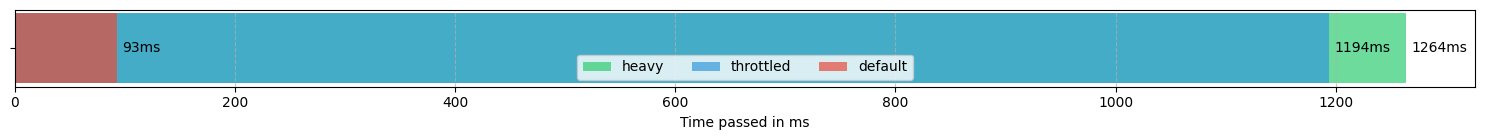

In [33]:
fig, ax = plt.subplots(figsize=(15, 1.5))

fcp_values = [df['fcp'].quantile(0.75) for df in dfs.values()]

bar_height = 0.25
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = []
for i, (name, value) in enumerate(zip(reversed(dfs.keys()), reversed(fcp_values))):
    bar = ax.barh(0.5, value, height=bar_height, 
                 label=name, color=colors[i], alpha=0.7)
    bars.append(bar)

ax.set_yticks([0.5])
ax.set_yticklabels([''])
ax.set_xlabel('Time passed in ms')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar[0].get_width()
    ax.text(width + 5, bar[0].get_y() + bar[0].get_height()/2, 
            f'{fcp_values[-(i+1)]:.0f}ms', 
            va='center')

ax.legend(loc='lower center', ncols=3)

plt.tight_layout()

plt.show()

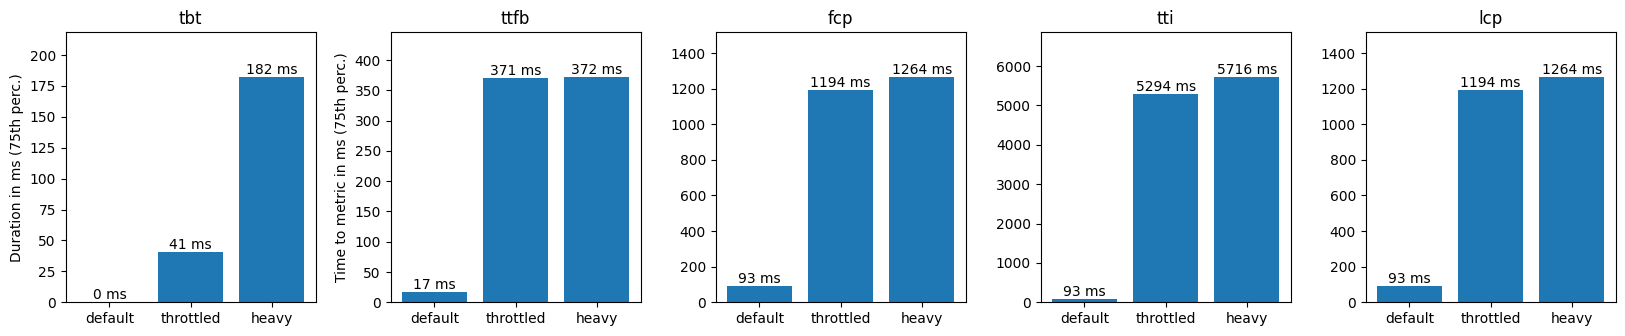

In [34]:
features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']
fig, axes = plt.subplots(ncols=len(features), figsize=(20, 3))
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)

for idx, feature in enumerate(features):
    percentiles = {d: dfs[d][feature].quantile(0.75) for d in dfs.keys()}
    bars = axes[idx].bar(percentiles.keys(), percentiles.values())
    
    max_height = max(percentiles.values())
    axes[idx].set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        label = f'{int(round(height, 0))} ms'
        axes[idx].text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom')
    
    axes[idx].set_title(feature)
    if idx == 0:
        axes[idx].set_ylabel('Duration in ms (75th perc.)')
    if idx == 1:
        axes[idx].set_ylabel('Time to metric in ms (75th perc.)')

plt.show()

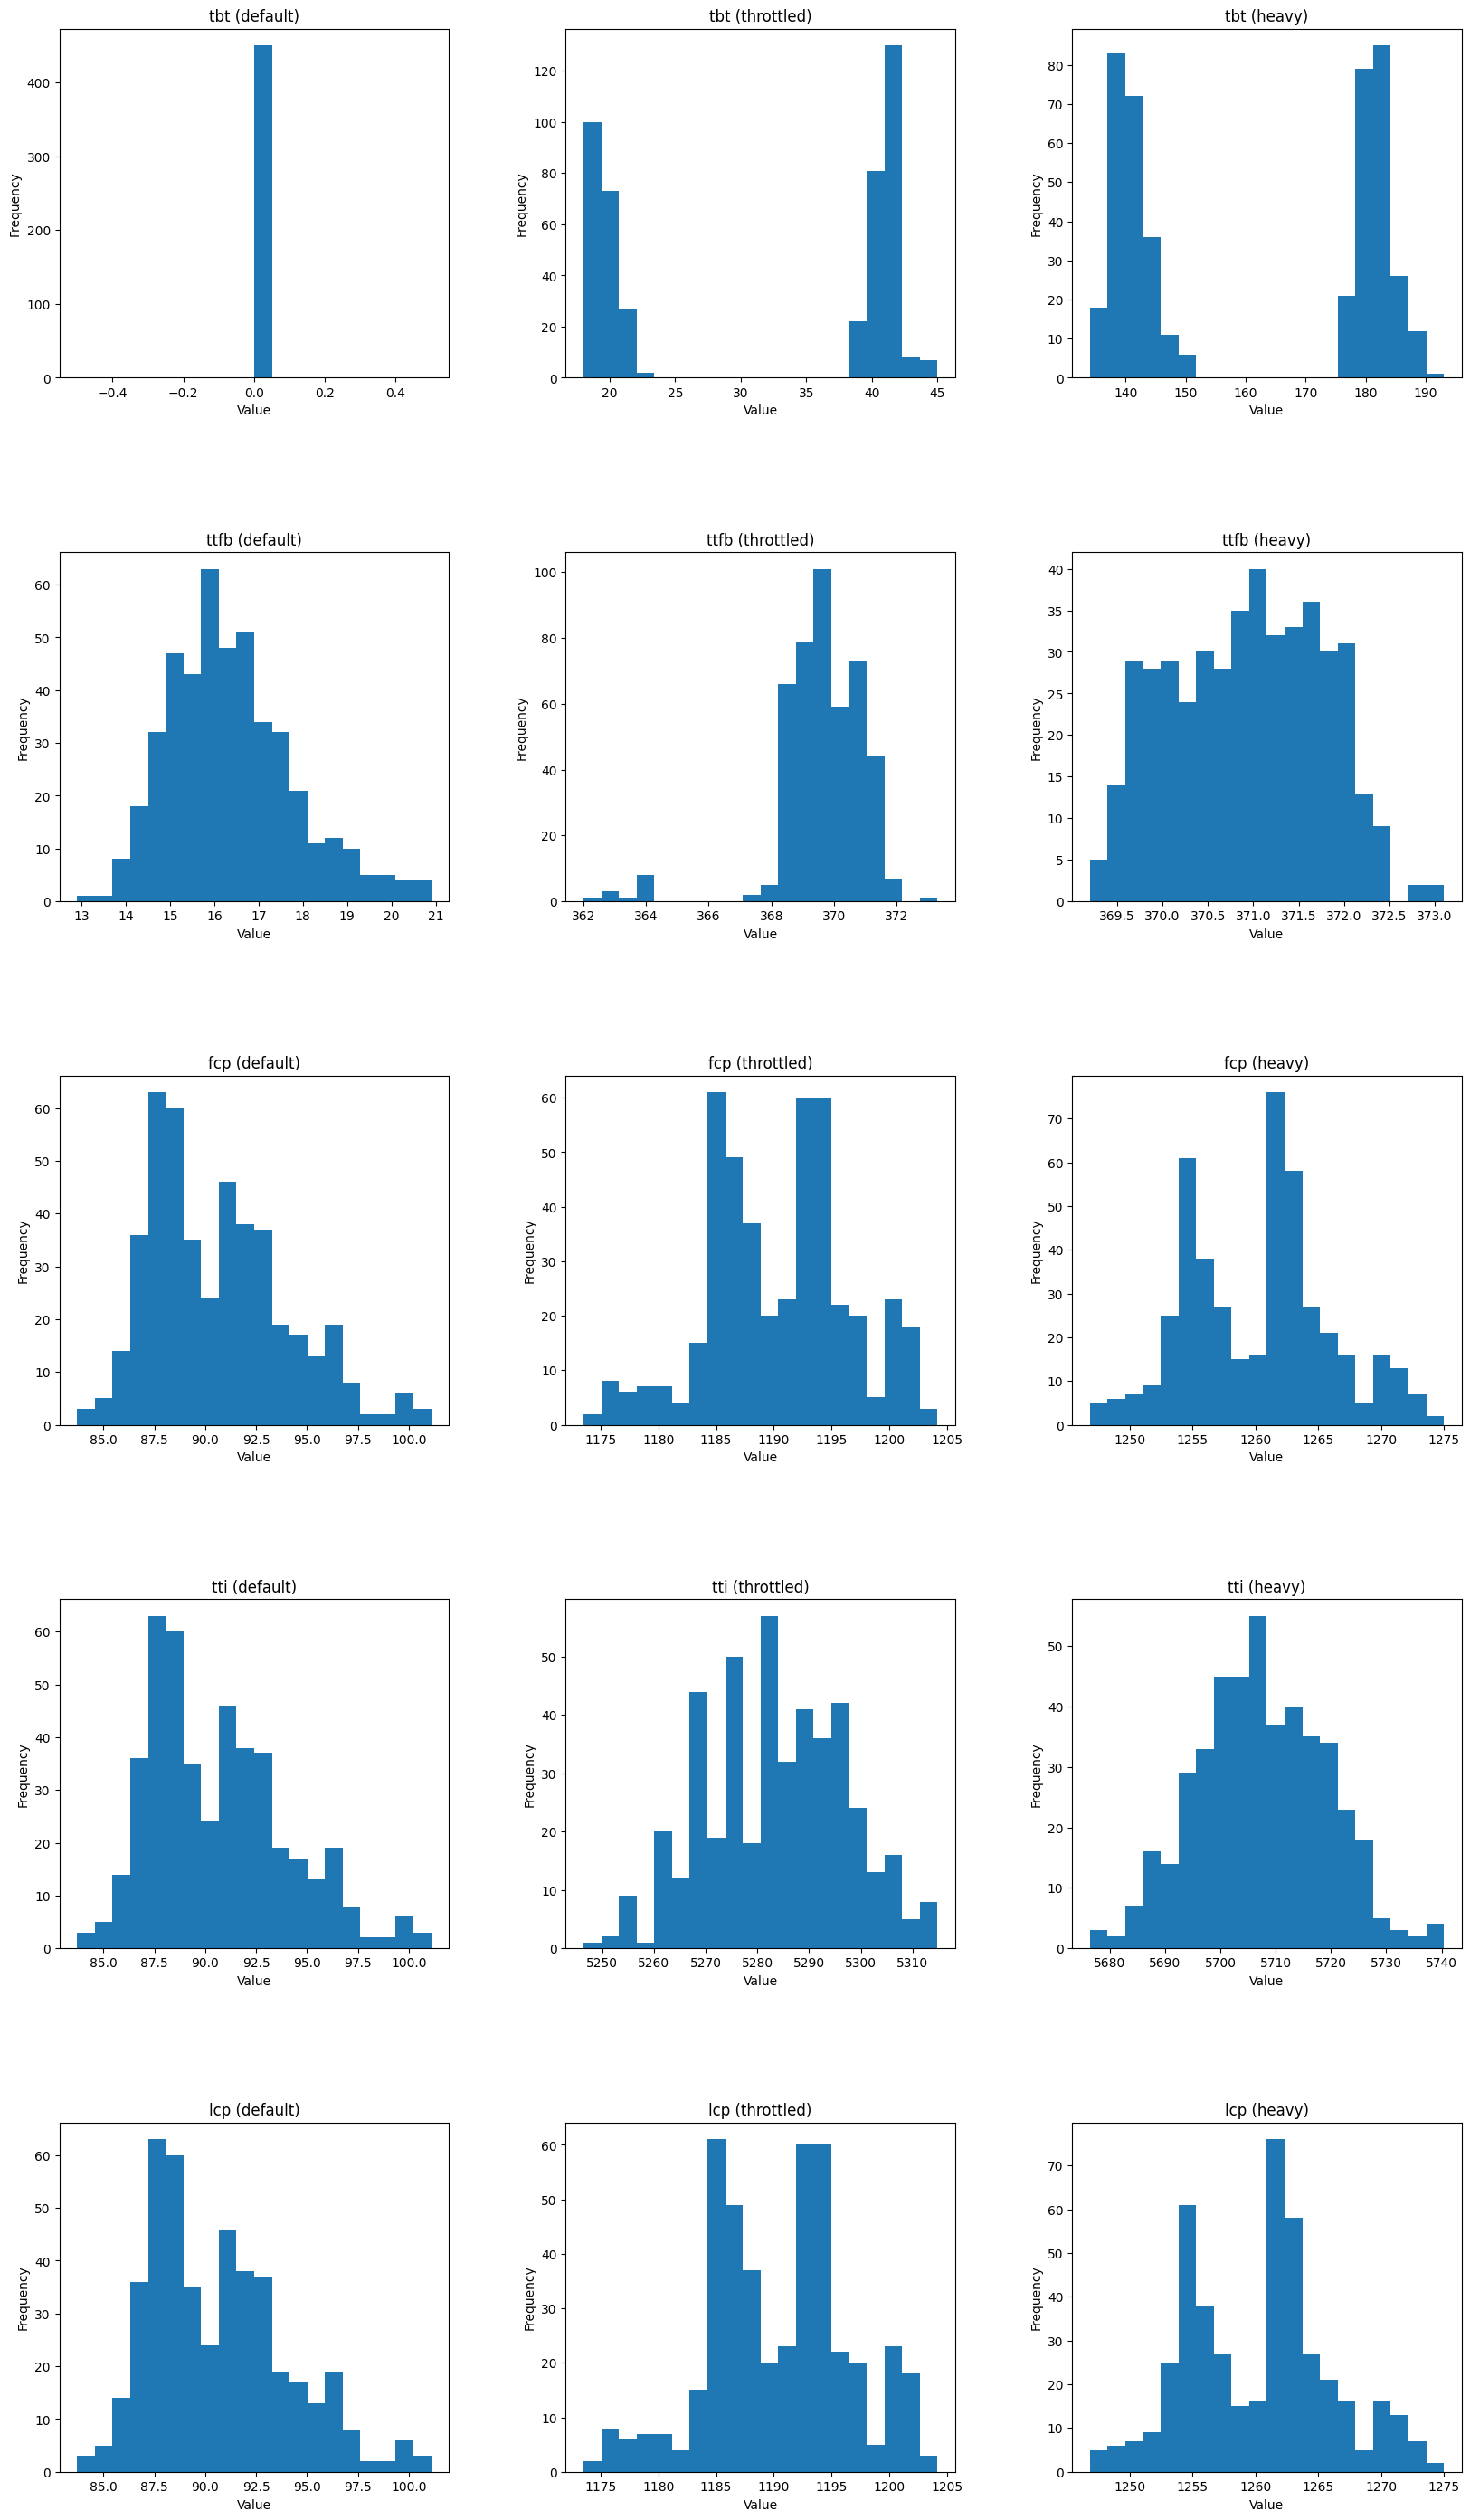

In [35]:
target_features = ['tbt', 'ttfb', 'fcp', 'tti', 'lcp']

fig, axes = plt.subplots(nrows=len(target_features), ncols=len(dfs.keys()), figsize=(20, 6*len(target_features)))
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95, bottom=0.05)

for y, f in enumerate(target_features):
    for x, d in enumerate(dfs.keys()):
        axes[y, x].hist(dfs[d][f], bins=20)
        axes[y, x].set_title(f'{f} ({d})')
        axes[y, x].set_xlabel('Value')
        axes[y, x].set_ylabel('Frequency')

plt.show()

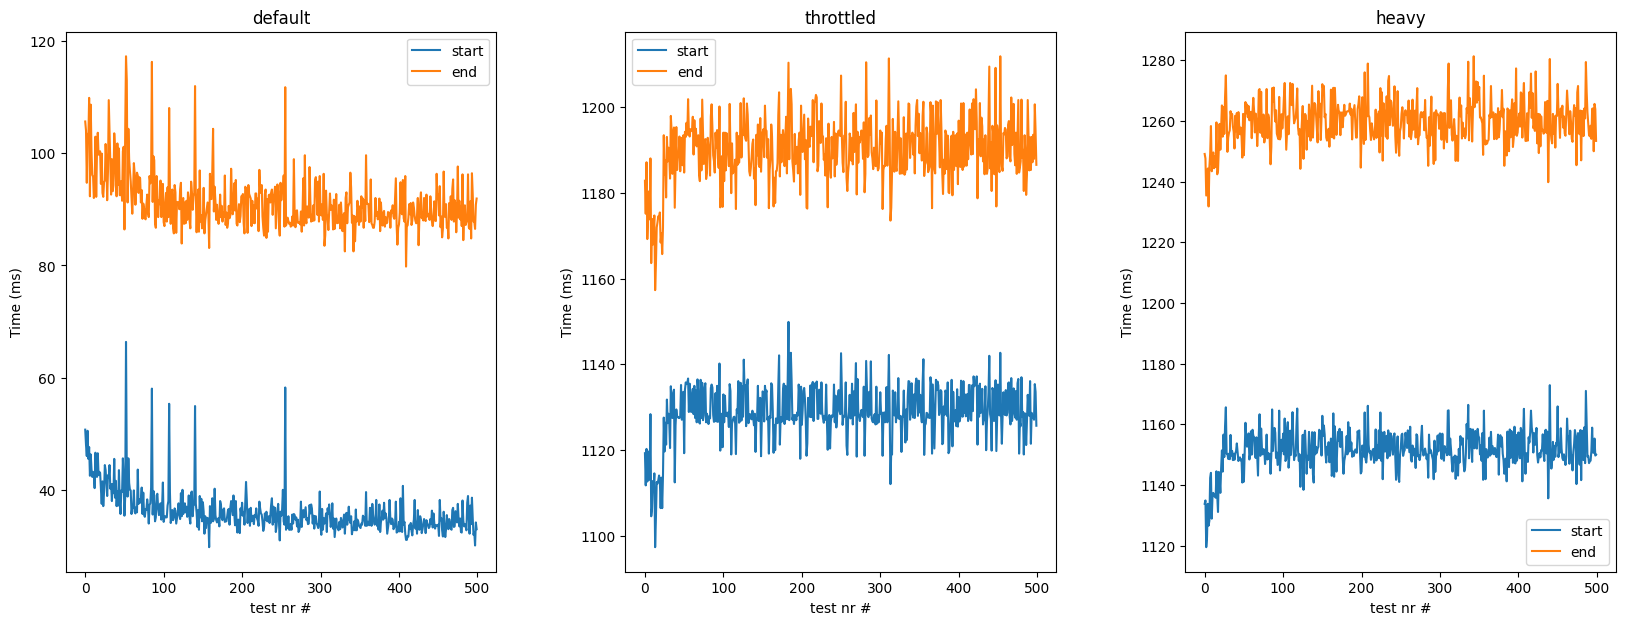

In [36]:
det_df = pd.read_csv(f'{path}details/2024-12-17T11:09:51.660Z_details-ssrh-sd.csv', sep=',')
det_df_t = pd.read_csv(f'{path}details/2024-12-17T12:56:03.626Z_details-ssrh-sd-throttled.csv', sep=',')
det_df_ht = pd.read_csv(f'{path}details/2024-12-17T14:52:01.364Z_details-ssrh-sd-throttled-heavy.csv', sep=',')

lcp_dfs = {
  'default': det_df[(det_df['type'] == 'LCP') & (det_df['idx'] > 5)].reset_index(drop=True),
  'throttled': det_df_t[(det_df_t['type'] == 'LCP') & (det_df_t['idx'] > 5)].reset_index(drop=True),
  'heavy': det_df_ht[(det_df_ht['type'] == 'LCP') & (det_df_ht['idx'] > 5)].reset_index(drop=True),
}
lcp_features = ['start','end','duration','name','element','url','id']


def plot_lcp_line(_df, loc, idx):
  for f in ['start', 'end']:
    loc.plot(_df[f], label=f)
  
  loc.set_title("LCP")
  loc.set_ylabel('Time (ms)')
  loc.set_xlabel('test nr #')
  loc.legend()

graph_row(plot_lcp_line, lcp_dfs, height=6)
plt.show()